<a href="https://colab.research.google.com/github/kitty57/classifiers/blob/main/GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses a gender classification dataset and trains a neural network using a pretrained imagenet model to classify images.

# ***Gender classifictaion using Pytorch***

In [ ]:
!pip install opendatasets --upgrade --quiet

## **Preparing the Data**

In [ ]:
import opendatasets as od
dataset_url="https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./gender-classification-dataset" (use force=True to force download)


In [ ]:
import os
data_dir="/content/gender-classification-dataset"
os.listdir(data_dir)

['.ipynb_checkpoints', 'test', 'Training']

In [ ]:
#creating transforms
import torchvision.transforms as T
stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms=T.Compose([T.Resize(64),
                      T.Pad(8,padding_mode='reflect'),
                      T.RandomCrop(64),
                      T.RandomHorizontalFlip(),
                      T.ToTensor(),
                      T.Normalize(*stats,inplace=True)
                       ])

In [ ]:
# Creating the dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

dataset=ImageFolder(data_dir+'/Training',transform=train_tfms)
len(dataset)

47009

In [ ]:
classes=os.listdir(data_dir+'/Training')

In [ ]:
dataset.classes

['female', 'male']

This data is classified into two clasess:male and female

## **Creating the Data loaders**





In [ ]:
import torch
from torch.utils.data import random_split
torch.manual_seed(42);
val_size=5000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(42009, 5000)

In [ ]:
import numpy as np
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)
batch_size=256
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True,worker_init_fn=worker_init_fn)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True,worker_init_fn=worker_init_fn)


In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

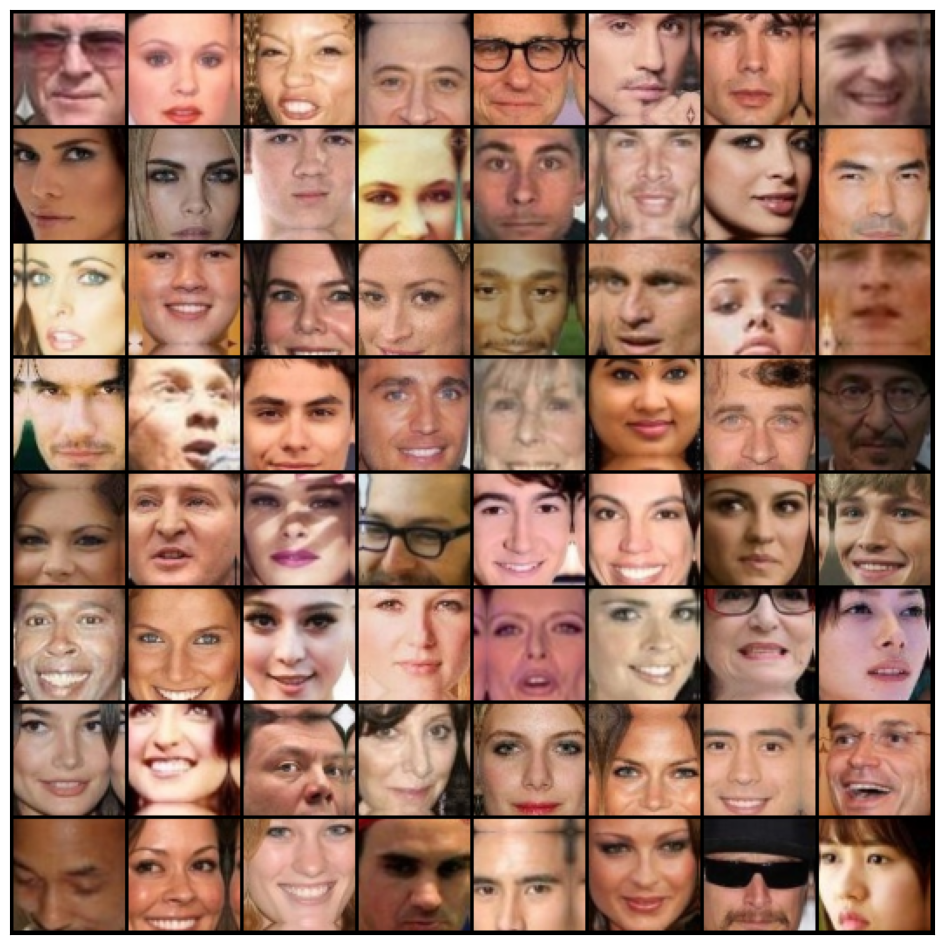

In [ ]:
import torch
show_batch(train_dl)

## **Moving the data to GPU**

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

## **Creating the model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#base for image classification
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models
# Using resnet34 and creating the model
class gendermodel(ImageClassificationBase):
  def __init__(self,num_classes,pretrained=True):
    super().__init__()
    self.net=models.resnet34(pretrained=pretrained)
    self.net.fc=nn.Linear(self.net.fc.in_features,num_classes)
  def forward(self,xb):
    return self.net(xb)


In [ ]:
num_classes=len(classes)
num_classes

2

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
model=gendermodel(num_classes)
to_device(model,device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


gendermodel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.2660267353057861, 'val_acc': 0.502566933631897}]

## **Training the model**

In [ ]:
epochs=5
opt_func=torch.optim.Adam
lr=1e-3

In [ ]:
history += fit(epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 0.7490, val_loss: 0.7044, val_acc: 0.5872
Epoch [1], train_loss: 0.3937, val_loss: 0.3358, val_acc: 0.8892
Epoch [2], train_loss: 0.1874, val_loss: 0.1998, val_acc: 0.9222
Epoch [3], train_loss: 0.1579, val_loss: 0.2029, val_acc: 0.9206
Epoch [4], train_loss: 0.1436, val_loss: 0.2403, val_acc: 0.9094


## **Testing the Model**

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=train_tfms)

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: female , Predicted: female


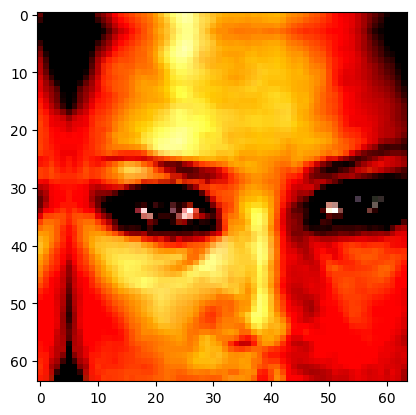

In [ ]:
img,label=test_dataset[10]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


Label: female , Predicted: female


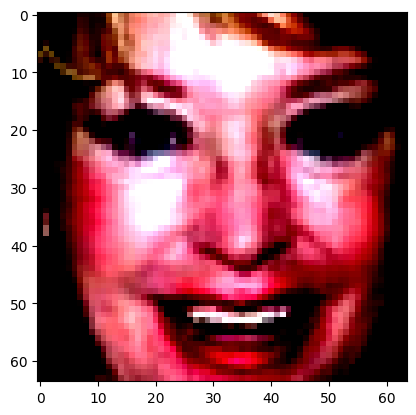

In [ ]:
img,label=test_dataset[5306]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: male , Predicted: male


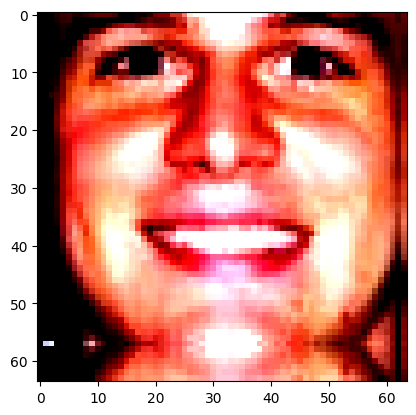

In [ ]:
img,label=test_dataset[11000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.20467104017734528, 'val_acc': 0.9234937429428101}

In [ ]:
torch.save(model.state_dict(), 'gender-classification.pth')

# **Summary**
In this project, the power of transfer learning has been harnessed to train a deep learning model that classifies images into two categories:

1.   "Female"
2.   "Male"

The concept of transfer learning involves leveraging knowledge gained from a previously trained model, and applying it to a new, similar problem. In our case, the pre-existing model that has been utilized is trained on the ImageNet dataset, a large scale visual recognition challenge database designed for use in visual object recognition software research.

The model built in this project has shown significant performance on the test dataset, effectively classifying the images into their respective categories.

Further enhancements to this model could potentially include fine-tuning the model with additional data or exploring different model architectures to find the most optimal solution for the given problem. Overall, the successful implementation of this project underscores the powerful potential of transfer learning in the field of deep learning.